# Expectation model choices
This notebook explains the rationale for our choice of expectation model.

Import modules

In [1]:
# Papermill parameters
coverage = 0

In [2]:
# Import modules
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.lines import Line2D
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import r2_score

from src import constants as C

# Set seaborn context
sns.set_context("paper")

Load data

In [3]:
# Load mutational model summary statistics
df = pd.read_csv(C.OBSERVED_VARIANTS_COUNTS_SYN, sep="\t")

# Find the proportion of variants observed
df["obs"] = df["obs"] / df["pos"]

## Inspect the data

Text(0, 0.5, 'Proportion observed')

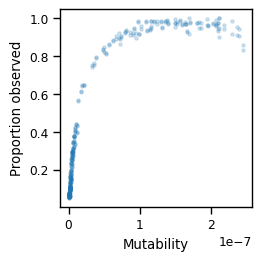

In [4]:
# Create figure
fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5), layout="constrained")

# Plot proportion observed against mutability
ax.scatter(x=df["mu"], y=df["obs"], alpha=0.2, marker=".")
ax.set_xlabel("Mutability")
ax.set_ylabel("Proportion observed")

There is a log-linear relationship between the proportion of synonymous variants and the mutability of each constext. Below we linearise the data with a log transform of the dependent variable.

/mnt/iusers01/bk01/m40482ab/miniforge3/envs/ukb/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, 'Proportion observed')

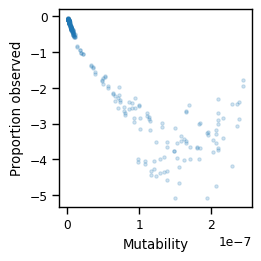

In [5]:
# Create figure
fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5), layout="constrained")

# Plot proportion observed against mutability
ax.scatter(x=df["mu"], y=np.log(1 - df["obs"]), alpha=0.2, marker=".")
ax.set_xlabel("Mutability")
ax.set_ylabel("Proportion observed")

After log transformation of the dependent variable, there is a nearly linear relationship.

### Drop saturated contexts
The error above is because some contexts are saturated (i.e. the proportion observed == 1). For these contexts, there is an error when we try to calculate np.log(0). It's best to drop any saturated contexts.

In [6]:
print(f"Contexts: {len(df)}")
print(
    f'There are {(df["obs"]==1).sum()} observations for which the proportion observed == 1. Drop them.'
)

# Drop saturated contexts
nonsat = df[df["obs"] != 1].copy()
print(f"Contexts remaining: {len(nonsat)}")

Contexts: 304
There are 3 observations for which the proportion observed == 1. Drop them.
Contexts remaining: 301


### Visualise CpGs and non-CpGs
CpGs are more mutable and should have a higher proportion of synonymous variants observed.

In [7]:
# Treat CpG transitions separately
ncg = nonsat[nonsat["variant_type"] != "CpG"].copy()
cpg = nonsat[nonsat["variant_type"] == "CpG"].copy()

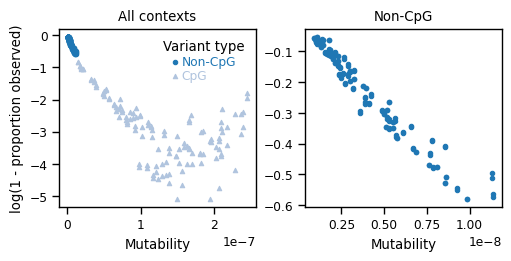

In [8]:
def plot_cpgs():
    # Create figure
    fig, axs = plt.subplots(1, 2, figsize=(5, 2.5), sharey=False, layout="constrained")

    # Plot CpG sites
    axs[0].scatter(
        x=ncg["mu"],
        y=np.log(1 - ncg["obs"]),
        alpha=1,
        marker="o",
        s=10,
        label="Non-CpG",
    )
    axs[0].scatter(
        x=cpg["mu"],
        y=np.log(1 - cpg["obs"]),
        alpha=1,
        marker="^",
        s=10,
        label="CpG",
        color="lightsteelblue",
    )
    axs[0].set_title("All contexts")
    axs[0].set_ylabel("log(1 - proportion observed)")
    axs[0].legend(
        title="Variant type",
        frameon=False,
        labelcolor="linecolor",
        handletextpad=-0.5,
        labelspacing=0.1,
        alignment="left",
    )

    # Plot non-CpG sites
    axs[1].scatter(x=ncg["mu"], y=np.log(1 - ncg["obs"]), alpha=1, marker="o", s=10)
    axs[1].set_title("Non-CpG")

    for ax in axs:
        ax.set_xlabel("Mutability")


plot_cpgs()

### Number of possible variants
The number of possible variants in each context is likely to be an important factor in building a model.

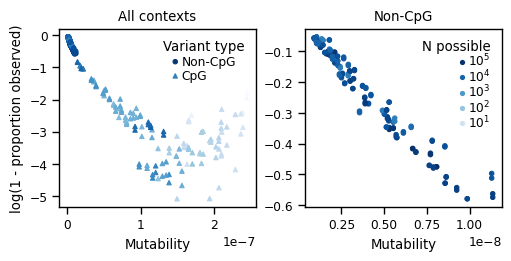

In [9]:
def plot_n_pos():
    # Create figure
    fig, axs = plt.subplots(1, 2, figsize=(5, 2.5), sharey=False, layout="constrained")

    # Create colour map
    col_norm = colors.LogNorm(vmin=cpg["pos"].min(), vmax=ncg["pos"].max())

    # Create colour map legend
    cmap = plt.cm.Blues
    legend_elements = [
        Line2D(
            [0], [0], marker="o", color="w", markerfacecolor=cmap(0.2), label="$10^1$"
        ),
        Line2D(
            [0], [0], marker="o", color="w", markerfacecolor=cmap(0.4), label="$10^2$"
        ),
        Line2D(
            [0], [0], marker="o", color="w", markerfacecolor=cmap(0.6), label="$10^3$"
        ),
        Line2D(
            [0], [0], marker="o", color="w", markerfacecolor=cmap(0.8), label="$10^4$"
        ),
        Line2D(
            [0], [0], marker="o", color="w", markerfacecolor=cmap(0.99), label="$10^5$"
        ),
    ]

    # Plot CpG sites
    axs[0].scatter(
        x=ncg["mu"],
        y=np.log(1 - ncg["obs"]),
        alpha=1,
        marker="o",
        s=10,
        label="Non-CpG",
        c=ncg["pos"],
        norm=col_norm,
        cmap="Blues",
    )
    axs[0].scatter(
        x=cpg["mu"],
        y=np.log(1 - cpg["obs"]),
        alpha=1,
        marker="^",
        s=10,
        label="CpG",
        c=cpg["pos"],
        norm=col_norm,
        cmap="Blues",
    )
    axs[0].set_title("All contexts")
    axs[0].set_ylabel("log(1 - proportion observed)")
    axs[0].legend(
        title="Variant type",
        frameon=False,
        labelcolor="linecolor",
        handletextpad=-0.5,
        labelspacing=0.1,
        alignment="left",
    )

    # Plot non-CpG sites
    axs[1].scatter(
        x=ncg["mu"],
        y=np.log(1 - ncg["obs"]),
        alpha=1,
        marker="o",
        s=10,
        c=ncg["pos"],
        norm=col_norm,
        cmap="Blues",
    )
    axs[1].set_title("Non-CpG")

    # Colormap legend
    axs[1].legend(
        title="N possible",
        handles=legend_elements[::-1],
        frameon=False,
        alignment="right",
        labelspacing=-0.1,
        handletextpad=-0.5,
        # title_fontsize=20,
        # fontsize=16,
        loc="upper right",
    )

    for ax in axs:
        ax.set_xlabel("Mutability")


plot_n_pos()

Highly mutable CpG positions generally have fewer possible variants. This probably explains the heteroskedasticity in the proportion of variants observed.

## Modelling CpG and non-CpG variants together

### OLS model

In [10]:
# Define the variables
# Use non-saturated contexts
y = np.log(1 - nonsat["obs"])  # Transformed dependent variable
X = sm.tools.add_constant(nonsat["mu"])
w = 1  # No weights

# Build the model
model = sm.WLS(
    y,
    X,
    weights=w,
)
results = model.fit()
results.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                    obs   R-squared:                       0.790
Model:                            WLS   Adj. R-squared:                  0.790
No. Observations:                 301   F-statistic:                     1127.
Covariance Type:            nonrobust   Prob (F-statistic):          1.84e-103
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3547      0.049     -7.221      0.000      -0.451      -0.258
mu         -1.812e+07    5.4e+05    -33.578      0.000   -1.92e+07   -1.71e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.6e-12. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

A simple OLS model performs well. Below, we try weighting the model by the number of possible variants.

### WLS model

In [11]:
# Define the variables
# Use non-saturated contexts
y = np.log(1 - nonsat["obs"])  # Transformed dependent variable
X = sm.tools.add_constant(nonsat["mu"])
w = nonsat["pos"]

# Build the model
wmodel = sm.WLS(
    y,
    X,
    weights=w,
)
wresults = wmodel.fit()
wresults.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                    obs   R-squared:                       0.922
Model:                            WLS   Adj. R-squared:                  0.922
No. Observations:                 301   F-statistic:                     3552.
Covariance Type:            nonrobust   Prob (F-statistic):          5.64e-168
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1436      0.008    -18.501      0.000      -0.159      -0.128
mu         -2.704e+07   4.54e+05    -59.598      0.000   -2.79e+07   -2.61e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.35e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

There is a substantial improvement in the R2, F statistic, and t statistic in the weighted model.

### WLS model performance on CpG and non-CpG contexts

R2 for CpG contexts: 0.6277945889286111
R2 for non-CpG contexts: 0.6503875083423488


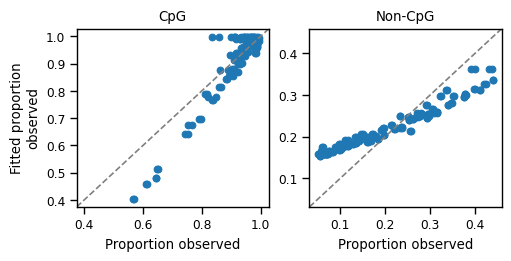

In [12]:
# Create the figure
fig, axs = plt.subplots(1, 2, figsize=(5, 2.5), layout="constrained")

# CpG contexts
## Create the variables
x = cpg["obs"]
y = 1 - np.exp(wresults.predict(sm.tools.add_constant(cpg["mu"])))

print(f"R2 for CpG contexts: {r2_score(x,y)}")

## Scatter plot
axs[0].scatter(x, y)
axs[0].set_xlabel("Proportion observed")
axs[0].set_ylabel("Fitted proportion\nobserved")
axs[0].set_title("CpG")

## Set axis limits
xy_min = min((axs[0].get_xlim()[0], axs[0].get_ylim()[0]))
xy_max = max((axs[0].get_xlim()[1], axs[0].get_ylim()[1]))
axs[0].set_xlim(xy_min, xy_max)
axs[0].set_ylim(xy_min, xy_max)

## Add x = y line
axs[0].axline((0, 0), slope=1, color="grey", linestyle="--")

# Non-CpG contexts
## Create the variables
_x = ncg["obs"]
_y = 1 - np.exp(wresults.predict(sm.tools.add_constant(ncg["mu"])))

## Print R2 values
print(f"R2 for non-CpG contexts: {r2_score(_x,_y)}")

## Scatter plot
axs[1].scatter(_x, _y)
axs[1].set_xlabel("Proportion observed")
axs[1].set_title("Non-CpG")

## Set axis limits
xy_min = min((axs[1].get_xlim()[0], axs[1].get_ylim()[0]))
xy_max = max((axs[1].get_xlim()[1], axs[1].get_ylim()[1]))
axs[1].set_xlim(xy_min, xy_max)
axs[1].set_ylim(xy_min, xy_max)

## Add x = y line
axs[1].axline((0, 0), slope=1, color="grey", linestyle="--")

The model performs reasonably well for CpG sites, but less well for non-CpG sites. There is an argument for fitting two separate models: one for CpG sites, one for non-CpG sites. What proportion of synonymous contexts are CpG sites?

In [13]:
# Calculate the proportion of synonymous contexts which are CpG sites
df.groupby("variant_type")["pos"].sum() / df["pos"].sum()

variant_type
CpG        0.030743
non-CpG    0.969257
Name: pos, dtype: float64

Only ~3% of synonymous contexts are CpG sites. It the poor performance of the model on non-CpG sites is therefore not acceptable.

## Separate models for CpG and non-CpG sites

### CpG contexts

In [14]:
# Define the variables
# Use non-saturated contexts
y = np.log(1 - cpg["obs"])  # Transformed dependent variable
X = sm.tools.add_constant(cpg["mu"])
w = cpg["pos"]

# Build the model
cpg_model = sm.WLS(
    y,
    X,
    weights=w,
)
cpg_results = cpg_model.fit()
cpg_results.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                    obs   R-squared:                       0.842
Model:                            WLS   Adj. R-squared:                  0.841
No. Observations:                 125   F-statistic:                     654.6
Covariance Type:            nonrobust   Prob (F-statistic):           4.39e-51
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6515      0.078     -8.310      0.000      -0.807      -0.496
mu         -2.154e+07   8.42e+05    -25.584      0.000   -2.32e+07   -1.99e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.13e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The CpG model is fairly performant.

### Non-CpG contexts
Non-CpG contexts have a more linear relationship between proportion observed and mutability. Does a log-linear model still outperform a simple linear model?

#### Linear model

In [15]:
# Define the variables
# Use non-saturated contexts
y = ncg["obs"]  # The dependent variable is not transformed
X = sm.tools.add_constant(ncg["mu"])
w = ncg["pos"]

# Build the model
ncg_model = sm.WLS(
    y,
    X,
    weights=w,
)
ncg_results = ncg_model.fit()
ncg_results.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                    obs   R-squared:                       0.953
Model:                            WLS   Adj. R-squared:                  0.953
No. Observations:                 176   F-statistic:                     3546.
Covariance Type:            nonrobust   Prob (F-statistic):          1.20e-117
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0366      0.004     10.070      0.000       0.029       0.044
mu          4.185e+07   7.03e+05     59.549      0.000    4.05e+07    4.32e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.56e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Log-linear model

In [16]:
# Define the variables
# Use non-saturated contexts
y = np.log(1 - ncg["obs"])  # Transformed dependent variable
X = sm.tools.add_constant(ncg["mu"])
w = ncg["pos"]

# Build the model
ncg_model = sm.WLS(
    y,
    X,
    weights=w,
)
ncg_results = ncg_model.fit()
ncg_results.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                    obs   R-squared:                       0.965
Model:                            WLS   Adj. R-squared:                  0.965
No. Observations:                 176   F-statistic:                     4787.
Covariance Type:            nonrobust   Prob (F-statistic):          1.60e-128
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0165      0.004     -3.959      0.000      -0.025      -0.008
mu         -5.578e+07   8.06e+05    -69.187      0.000   -5.74e+07   -5.42e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.56e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The log-linear model has higher R2, so we'll go with it.

### Separate model performance on CpG and non-CpG contexts

R2 for CpG contexts: 0.8680726981056619
R2 for non-CpG contexts: 0.9629295761896047


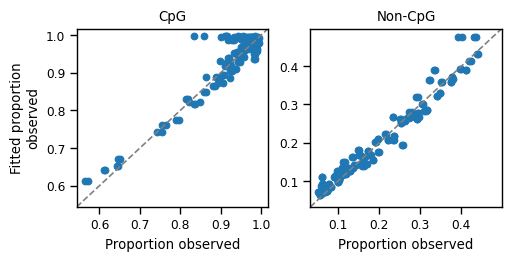

In [17]:
# Create the figure
fig, axs = plt.subplots(1, 2, figsize=(5, 2.5), layout="constrained")

# CpG contexts
## Create the variables
x = cpg["obs"]
y = 1 - np.exp(cpg_results.predict(sm.tools.add_constant(cpg["mu"])))

print(f"R2 for CpG contexts: {r2_score(x,y)}")

## Scatter plot
axs[0].scatter(x, y)
axs[0].set_xlabel("Proportion observed")
axs[0].set_ylabel("Fitted proportion\nobserved")
axs[0].set_title("CpG")

## Set axis limits
xy_min = min((axs[0].get_xlim()[0], axs[0].get_ylim()[0]))
xy_max = max((axs[0].get_xlim()[1], axs[0].get_ylim()[1]))
axs[0].set_xlim(xy_min, xy_max)
axs[0].set_ylim(xy_min, xy_max)

## Add x = y line
axs[0].axline((0, 0), slope=1, color="grey", linestyle="--")

# Non-CpG contexts
## Create the variables
_x = ncg["obs"]
_y = 1 - np.exp(ncg_results.predict(sm.tools.add_constant(ncg["mu"])))

## Print R2 values
print(f"R2 for non-CpG contexts: {r2_score(_x,_y)}")

## Scatter plot
axs[1].scatter(_x, _y)
axs[1].set_xlabel("Proportion observed")
axs[1].set_title("Non-CpG")

## Set axis limits
xy_min = min((axs[1].get_xlim()[0], axs[1].get_ylim()[0]))
xy_max = max((axs[1].get_xlim()[1], axs[1].get_ylim()[1]))
axs[1].set_xlim(xy_min, xy_max)
axs[1].set_ylim(xy_min, xy_max)

## Add x = y line
axs[1].axline((0, 0), slope=1, color="grey", linestyle="--")

The separate models are clearly superior in each context. Especially for non-CpG sites.

In [18]:
%%capture

# Export current notebook to markdown

import os

os.system(
    f"jupyter nbconvert \
        --output '{Path(os.path.abspath('')).stem}_coverage_{coverage}' \
        --output-dir='data/logs' \
        --no-input \
        --to markdown \
        notebooks/01_expectation_model_choices.ipynb"
)

[NbConvertApp] Converting notebook notebooks/01_expectation_model_choices.ipynb to markdown
/mnt/iusers01/bk01/m40482ab/miniforge3/envs/ukb/lib/python3.8/site-packages/nbformat/__init__.py:93: MissingIDFieldWarning: Code cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)
[NbConvertApp] Support files will be in ukb_constraint_coverage_0_files/
[NbConvertApp] Writing 9981 bytes to data/logs/ukb_constraint_coverage_0.md
